In [1]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

# Required Libraries

In [2]:
import numpy as np

# dataset preprocessing
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

# visualization
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# cross validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV

<IPython.core.display.Javascript object>

# NSL-KDD Dataset Introduction

The NSL-KDD dataset was collated in order to mitigate the problems of the KDD'99 dataset. The KDD'99 dataset attracted the attention of many researchers due to the lack of public data sets for signature based intrusion detection systems (IDSs). Tavallaee et al. [1] found that the most significant issue with the 1999 dataset is that it contained a significant number of redundant instances such that classifiers were biased towards these instances while disregarding infrequent instances. However, it is often these infrequent instances that can be indicative of new devastating network intrusions.

Some of the improvements present in the NSL-KDD dataset is that all redundant instances were removed. Moreover, the number of records from each difficulty group was selected to be inversely proportional to the percentage of records in the original KDD dataset. Difficulty refers to how many of 21 classifiers were able to classify an instance correctly from the 1999 dataset. In addition, some of the instances in the original dataset contained unsystematic noise, thus these instances were discarded when constructing the improved dataset. Overall, the original KDD dataset was disproportionately distributed, thus rendering the classifiers ineffective in serving as a discriminative tool for detecting network intrusions that can be identified by signature.

The NSL-KDD dataset can be downloaded from: https://www.unb.ca/cic/datasets/nsl.html

Please note that a 20% subset of the whole dataset will be used due to the magnitude of the whole dataset (more than 120,000 instances). The 20% subset is also provided at the above link under the name 'KDDTrain+_20Percent.TXT'

# Dataset Overview

In [3]:
df = pd.read_csv("ids.csv")
print(f"Number of Instances: {df.shape[0]}")
print(f"Number of Features (including class): {df.shape[1]}")
df.head()

Number of Instances: 25192
Number of Features (including class): 42


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


<IPython.core.display.Javascript object>

In [4]:
num_of_missing_values = df.isnull().sum().sum()
print("There are %d missing values in the dataset." % (num_of_missing_values))

There are 0 missing values in the dataset.


<IPython.core.display.Javascript object>

In [5]:
data_types = df.dtypes.value_counts().to_frame().reset_index()
data_types.columns = ["Type", "Count"]
data_types

,Type,Count
0,int64,23
1,float64,15
2,object,4


<IPython.core.display.Javascript object>

In [6]:
categorical_features = df.select_dtypes(include=["object"])
categorical_features.head()

,protocol_type,service,flag,class
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,anomaly
3,tcp,http,SF,normal
4,tcp,http,SF,normal


<IPython.core.display.Javascript object>

## Feature Statistics

In [7]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

The majority of the continuous features such as duration, src_bytes, and dst_bytes have very large standard deviations and ranges. Thus, these continuous features will be transformed to a feature range of [0, 1] in the preprocessing phase

## Class Distribution

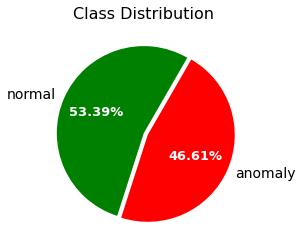

<IPython.core.display.Javascript object>

In [8]:
labels = df["class"].value_counts().index

fig, ax = plt.subplots()
_, _, autopcts = ax.pie(
    df["class"].value_counts(),
    textprops={"fontsize": 14},
    labels=labels,
    colors=("green", "red"),
    autopct="%.2f%%",
    startangle=60,
    explode=(0, 0.05),
)

plt.setp(autopcts, **{"color": "white", "weight": "bold", "fontsize": 13})
ax.set_title("Class Distribution", fontdict={"fontsize": 16})

plt.show()

Overall, the class distribution is slightly skewed towards the 'Normal' class, thus stratified cross validation (CV) will be used to ensure that the folds preserve the percentage of samples for each class. The 'Normal' class represents network traffic that is not indicative of an intrusion while the 'Anomaly' class represents network traffic that is associated with malicious behavior.

# Pre-processing

In [9]:
cols_to_drop = [col for col in list(df) if df[col].nunique() <= 1]
df = df.drop(columns=cols_to_drop)

<IPython.core.display.Javascript object>

All features with only 1 unique value are dropped since they are futile for a classification task. The only 2 features that have 1 unique value are 'num_outbound_cmds' and 'is_host_login'.

In [10]:
X = df.iloc[:, :-1]
y = df["class"]

<IPython.core.display.Javascript object>

The data is separated into two components. X contains the features of the dataset while y contains the class labels for each instance.

In [11]:
binary_features = df.columns[df.isin([0, 1]).all()].tolist()
binary_features

['land', 'urgent', 'logged_in', 'root_shell', 'num_shells', 'is_guest_login']

<IPython.core.display.Javascript object>

All the binary features do not need to be scaled to a feature range of [0, 1], thus the feature names are extracted from the dataframe.

In [12]:
numeric_features_nb = df.select_dtypes("number").columns.drop(binary_features).tolist()

<IPython.core.display.Javascript object>

All the numeric features that are non-binary, i.e., continuous, will be scaled to a feature range of [0, 1] using MinMaxScaler().

In [13]:
enc = OrdinalEncoder(handle_unknown="ignore")
mms = MinMaxScaler()

ct = make_column_transformer(
    (enc, ["protocol_type", "service", "flag"]),
    (mms, numeric_features_nb),
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

The 3 categorical features, 'protocol_type', 'service', and 'flag' are encoded using an ordinal encoder. The ordinal encoder transforms a categorical feature to an integer range in 0 to n_categories - 1. The above 3 feature seem to be nominal, thus I initially tried using one hot encoding. However, after using the ordinal encoder, I compared the accuracy of the models and found that all classifiers achieved higher accuracy using the ordinal encoder. Furthermore, the one hot encoder resulted in the 'service' feature being split into 66 distinct columns as that feature can take on 66 values. The higher accuracy of the classifiers using ordinal encoding on the categorical features demonstrates that although these feature may seem to be nominal based on the concepts they represent, they are highly likely to posses a natural ordering. The ordinal encoder is set to handle unknown feature values from the testing set during CV evaluation by ignoring such values. Thus, sklearn's ordinal encoder was used as opposed to the pandas ordinal encoder since it can handle unknown categorical features seen during CV.

The class labels did not need to be encoded since the majority of sklearn's classifiers automatically encode the target labels using a label encoder. All other features are already numeric, thus they were not encoded via the 'remainder="passthrough"' setting.

All these feature transformations (column transformations) will be used in a pipeline. A pipeline was used as it makes it easier to compose estimators since at every fit or predict call within the CV procedure, it will automatically apply the column transformations. This will prevent information leakage since the feature transformations will not be applied to the training set as a whole.

In [14]:
def extract_feature_names(ct):
    ct_temp = ct
    ct_temp.fit(X, y)
    features = []

    # disregard remainder = "passthrough"
    for transformer in ct_temp.transformers_[:-1]:
        features += transformer[2]

    return features


all_features = extract_feature_names(ct)

# have to define passedthrough_features since they were not explicitly stated
# when creating the column transformer
passedthrough_features = [
    "land",
    "urgent",
    "logged_in",
    "root_shell",
    "num_shells",
    "is_guest_login",
]
all_features = all_features + passedthrough_features

<IPython.core.display.Javascript object>

The feature names are extracted from the column transformer since the features will be re-ordered by the transformer. This will be used to extract the feature names when feature selection is used.

# Cross Validation (CV)

In [15]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)

<IPython.core.display.Javascript object>

As seen above, the class feature is relatively skewed towards the 'Normal' class, thus repeated stratified CV will be used for evaluation. Stratified 10-Fold CV will be run 3 times with different randomization in each repetition. Since randomized CV splitters such as RepeatedStratifiedKFold() can return different results for each call of the split, random_state is set to an integer in order to make the results reproducible across different runs.

# Naive Bayes

## Default Hyperparameters

In [16]:
pipe = make_pipeline(ct, GaussianNB())
scores = cross_val_score(pipe, X, y, cv=cv)
print(
    "%0.3f CV accuracy with a standard deviation of %0.3f."
    % (scores.mean(), scores.std())
)

0.895 CV accuracy with a standard deviation of 0.006.


<IPython.core.display.Javascript object>

## Hyperparameter Tuning

In [17]:
np.random.seed(1234)

pipe = make_pipeline(ct, GaussianNB())

smoothing_range = np.logspace(0, -15, num=200)

param_grid = {"gaussiannb__var_smoothing": smoothing_range}

search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)
search.fit(X, y)

print("Best hyperparameter (CV accuracy = %0.3f):" % search.best_score_)
print(search.best_params_)

Best hyperparameter (CV accuracy = 0.897):
{'gaussiannb__var_smoothing': 6.080224261649427e-09}


<IPython.core.display.Javascript object>

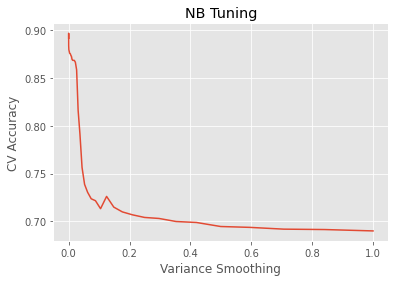

<IPython.core.display.Javascript object>

In [18]:
tuning_results = pd.DataFrame(search.cv_results_["params"])
tuning_results["mean_test_score"] = search.cv_results_["mean_test_score"]
tuning_results["mean_test_score"] = search.cv_results_["mean_test_score"]

plt.plot(
    tuning_results["gaussiannb__var_smoothing"],
    tuning_results["mean_test_score"],
)

plt.xlabel("Variance Smoothing")
plt.ylabel("CV Accuracy")
plt.title("NB Tuning")
plt.show()

The tuning of the variance smoothing parameter did not improve the CV accuracy of the NB classifier significantly. The CV accuracy increased by $2 \times 10^{-3}$. Nevertheless, it can be seen from the above graph that increasing the variance smoothing results in CV accuracy reductions as large as 20%. Variance smoothing has a default value of $1 \times 10^{-9}$ and works by adding a portion of the biggest variance of all the features to the feature variances in order to achieve calculation stability.

## Scheme Independent Feature Selection

In [19]:
le = LabelEncoder()
A = ct.fit_transform(X)
b = le.fit_transform(y)
lasso = LassoCV(random_state=1234).fit(A, b)
sfs_forward = SequentialFeatureSelector(lasso, direction="forward", n_jobs=-1).fit(A, b)

selected_features = [
    i for j, i in enumerate(all_features) if sfs_forward.get_support()[j]
]
print("Features selected by forward sequential selection: ")

pd.DataFrame({"Feature": selected_features})

Features selected by forward sequential selection: 


,Feature
0,protocol_type
1,wrong_fragment
2,hot
3,srv_count
4,srv_serror_rate
5,srv_rerror_rate
6,same_srv_rate
7,diff_srv_rate
8,srv_diff_host_rate
9,dst_host_count


<IPython.core.display.Javascript object>

In [20]:
A = ct.fit_transform(X)
b = le.fit_transform(y)
lasso = LassoCV(random_state=1234).fit(A, b)
sfs_forward = SequentialFeatureSelector(lasso, direction="backward", n_jobs=-1).fit(
    A, b
)

selected_features = [
    i for j, i in enumerate(all_features) if sfs_forward.get_support()[j]
]
print("Features selected by forward sequential selection: ")

pd.DataFrame({"Feature": selected_features})

Features selected by forward sequential selection: 


,Feature
0,protocol_type
1,wrong_fragment
2,hot
3,srv_count
4,srv_serror_rate
5,srv_rerror_rate
6,same_srv_rate
7,diff_srv_rate
8,srv_diff_host_rate
9,dst_host_count


<IPython.core.display.Javascript object>

A lasso linear model was used for sequential feature selection (SFS). Surprisingly, the greedy SFS in the forwards and backwards direction both resulted in the same features being selected. This is generally not the case. Backward SFS starts with all the features and greedily removes features in an iterative fashion. Forward SFS starts with no features and greedily adds features. Backward SFS is often preferable as forward SFS starts with no features and can terminate "early" when there are no gains in the CV accuracy without considering larger feature subsets. However, it was evident that forwards feature selection had a much lower runtime than backwards feature selection. Thus, these tradeoffs are similar to the ones seen when considering pre-pruning vs. post pruning for a decision tree classifier.

Guendouzi et al. [2] developed a new feature selection algorithm known as EDDE-LNS, which amalgamates Ensemblist Discrete Differential Evolution (EDDE) and large neighborhood search (LNS). They tested this algorithm on the original KDD'99 dataset and some of the most significant selected features were very similar to the ones obtained above using SFS, particularly for denial-of-service (DoS) based network intrusions.

In [21]:
X2 = df[selected_features]
y2 = df["class"]

enc2 = OrdinalEncoder(handle_unknown="ignore")
mms2 = MinMaxScaler()

# extract feature names to be scaled to a value in [0, 1]
scale_features = list(set(numeric_features_nb).intersection(set(X2.columns)))

ct2 = make_column_transformer(
    (enc2, ["protocol_type"]), (mms2, scale_features), remainder="passthrough"
)

<IPython.core.display.Javascript object>

The same preprocessing that was used for the original dataset is now applied to the new dataframe containing the selected features only. However, the column transformer is altered since only a subset of the features are selected, thus the other features do not need preprocessing.

In [22]:
pipe = make_pipeline(ct2, GaussianNB())
scores = cross_val_score(pipe, X2, y2, cv=cv)
print(
    "%0.3f CV accuracy with a standard deviation of %0.3f."
    % (scores.mean(), scores.std())
)

0.904 CV accuracy with a standard deviation of 0.006.


<IPython.core.display.Javascript object>

With only 19 out of 39 attributes, NB with feature selection and no parameter tuning achieved a better CV accuracy than NB without feature selection and NB without feature selection and parameter tuning. Although the CV accuracy increased by at most 0.017, only about 49% of the total features were used as input to the classifier. Thus, feature selection's benefit is two-fold, increasing the overall CV accuracy while reducing the number of input features. This can result in easier interpretability and analysis of the classifier.

In [23]:
# insert the best CV accuracy obtained by NB
best_classifiers = {"NB with FS": scores.mean()}

<IPython.core.display.Javascript object>

# Decision Tree (CART)

sklearn uses an optimized version of the CART algorithm.

## Default Parameters

In [24]:
pipe = make_pipeline(ct, DecisionTreeClassifier(criterion="entropy", random_state=1234))
scores = cross_val_score(pipe, X, y, cv=cv)
print(
    "%0.3f CV accuracy with a standard deviation of %0.3f."
    % (scores.mean(), scores.std())
)

0.995 CV accuracy with a standard deviation of 0.002.


<IPython.core.display.Javascript object>

The CV accuracy of the decision tree classifier using entropy as the splitting criterion is very high, thus parameter tuning is unnecessary.

In [25]:
pipe = make_pipeline(ct, DecisionTreeClassifier(criterion="gini", random_state=1234))
scores = cross_val_score(pipe, X, y, cv=cv)
print(
    "%0.3f CV accuracy with a standard deviation of %0.3f."
    % (scores.mean(), scores.std())
)

0.995 CV accuracy with a standard deviation of 0.001.


<IPython.core.display.Javascript object>

The accuracy of the decision tree classifier using the Gini index has approximately the same CV accuracy compared to using entropy as the splitting criterion. However, the Gini index CV accuracy has a lower standard deviation, thus we can construct a tighter confidence interval given a confidence level compared to the accuracy obtained when using entropy.

## Parameter Tuning

The decision tree classifier already has an accuracy that exceeds 99.5%, therefore parameter tuning is not necessary. Thus, a visualization of how the parameters impact the accuracy of the model is demonstrated.

In [26]:
pipe = make_pipeline(ct, DecisionTreeClassifier(random_state=1234))
criterion = ["gini", "entropy"]
depth_range = list(range(1, 41))
param_grid = {
    "decisiontreeclassifier__criterion": criterion,
    "decisiontreeclassifier__max_depth": depth_range,
}

search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1)

search.fit(X, y)
print("Best parameter (CV accuracy=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV accuracy=0.995):
{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 18}


<IPython.core.display.Javascript object>

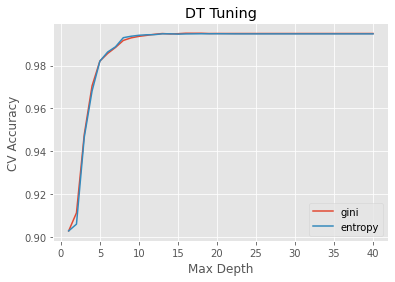

<IPython.core.display.Javascript object>

In [27]:
tuning_results = pd.DataFrame(search.cv_results_["params"])
tuning_results["mean_test_score"] = search.cv_results_["mean_test_score"]

for i in ["gini", "entropy"]:
    criterion = tuning_results[tuning_results["decisiontreeclassifier__criterion"] == i]
    plt.plot(
        criterion["decisiontreeclassifier__max_depth"],
        criterion["mean_test_score"],
        label=i,
    )

plt.legend()
plt.xlabel("Max Depth")
plt.ylabel("CV Accuracy")
plt.title("DT Tuning")
plt.show()

As seen from the above graph, as the max depth of the decision tree increases and approaches 10, the CV accuracy increases. However, as the max depth exceeds 10, the CV accuracy plateaus, indicating that the CV accuracy gains become small and eventually converge. Although it appears that a deeper tree has better accuracy, it will most likely be overfit to the training data meaning that the bias is decreased at the expense of increased variance. Using the Gini index compared to entropy as the splitting criterion does not have a significant impact on the CV accuracy.

In [28]:
# insert the best CV accuracy obtained by NB
best_classifiers["DT with PT"] = search.best_score_

<IPython.core.display.Javascript object>